## Training a simple NN to identify particles in PID

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot
import hist
import pyphysics as phys
import awkward as ak
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, Concatenate, GlobalAvgPool1D

2025-05-30 17:20:42.226710: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-30 17:20:42.227981: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 17:20:42.230760: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 17:20:42.237407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748618442.250603   37884 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748618442.25

### Preparing the data

In [5]:
df1 = uproot.open("./Outputs/tree_11Li_2H_1H_Ex_0.00.root:SimulationTree").arrays(library="pd") 
df2 = uproot.open("./Outputs/tree_11Li_2H_2H_Ex_0.00.root:SimulationTree").arrays(library="pd") 
df3 = uproot.open("./Outputs/tree_11Li_2H_3H_Ex_0.00.root:SimulationTree").arrays(library="pd") 

parts = ["p", "d", "t"]
dfs = [df1, df2, df3]
for i,df in enumerate(dfs):
    df = df.drop(columns=["profx"])
    df["profy"] = df["profy"].apply(lambda x : np.array(x))
    df["label"] = parts[i]
    dfs[i] = df
## And concat all transformed individual dfs
df = pd.concat(dfs)
# Gate on events of interes
df = df[df["dE1"] > 0]
df.head()

,dEgas,dE0,dE1,T3,theta3,RPx,T3After1,profy,label
0,0.218267,11.479183,8.230044,20.108731,34.441817,254.680336,0.000000,"[0.0004191933840047568, 0.0, 0.0, 0.0, 0.0, 0....",p
1,0.305491,8.457327,15.478861,24.344296,22.309028,148.015405,0.000000,"[0.0007218921091407537, 0.000720073061529547, ...",p
2,-0.042595,7.362828,13.566279,24.217738,21.008768,219.022179,3.314466,"[0.0007668694597668946, 0.0007578445947729051,...",p
3,0.094662,7.521955,12.172503,25.118176,16.637236,187.528524,5.319978,"[0.0003882489399984479, 0.0003868640342261642,...",p
4,0.149947,6.148745,10.291179,25.523476,17.121025,199.394260,8.963668,"[0.00023248372599482536, 0.0002352454903302714...",p


<BarContainer object of 3 artists>

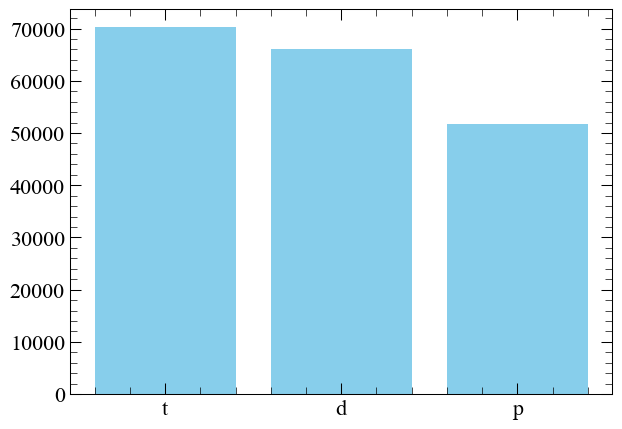

In [6]:
counts = df["label"].value_counts()
plt.bar(counts.index, counts.values, color="skyblue")

Minority label p with 51766 counts


<BarContainer object of 3 artists>

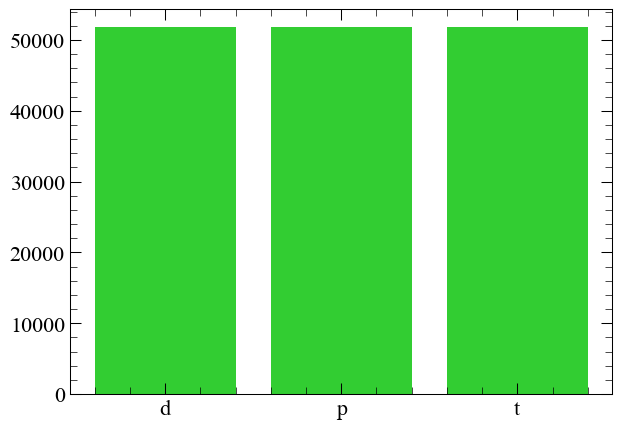

In [12]:
# Downsample so we have same counts for all clases... lowest counts are for protons
minority_counts = counts.min()
minority_label = counts.idxmin()
print(f"Minority label {minority_label} with {minority_counts} counts")

df_downsampled = df[df["label"] == minority_label]
for part in parts:
    if part == minority_label:
        continue
    sampled = df[df["label"] == part].sample(n=minority_counts, replace=False, random_state=42)
    df_downsampled = pd.concat([df_downsampled, sampled])

# Shuffle entries
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Rename it
data = df_downsampled

# Check downsampled has worked
ok_counts = data["label"].value_counts()
plt.bar(ok_counts.index, ok_counts.values, color="limegreen")

Plotting the data we will train

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7dc2ec68f430>, cbar=<matplotlib.colorbar.Colorbar object at 0x7dc2ec6aeb00>, text=[])

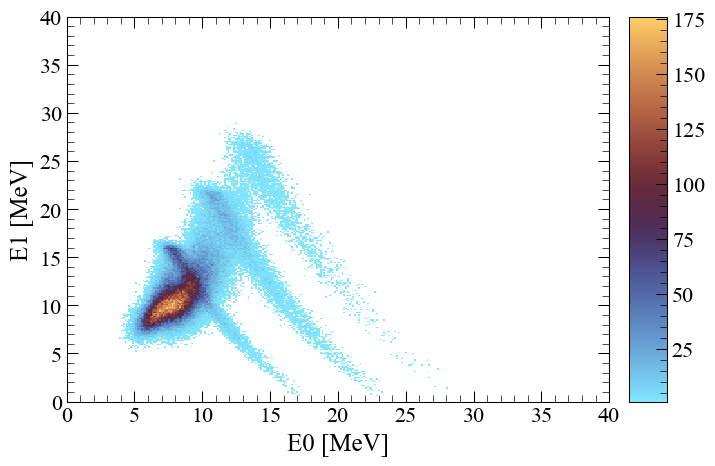

In [13]:
hdE01 = hist.Hist.new.Regular(300, 0, 40, label="E0 [MeV]").Regular(300, 0, 40, label="E1 [MeV]").Double()
hdE01.fill(data["dE0"], data["dE1"])

hdE01.plot(cmin=1, cmap="managua_r")

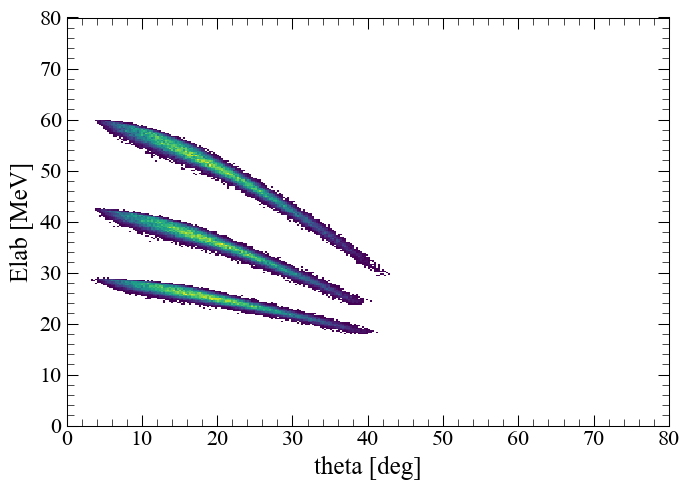

In [14]:
## Kinematics plot
hkins = {}
for part in ["p", "d", "t"]:
    hkin = hist.Hist.new.Reg(300, 0, 80, label="theta [deg]").Reg(300, 0, 80, label="Elab [MeV]").Double()
    gated = data[data.label == part] #type: ignore
    hkin.fill(gated.theta3, gated.T3) #type: ignore
    hkins[part] = hkin

fig, ax = plt.subplots(1, 1)
for p, h in hkins.items():
    h.plot(ax=ax, cmin=1, cbar=None)
fig.tight_layout()

In [17]:
# Split columns into "plain,float" type and "profile, vector" type
## usual float values will be used to train the DNN
## Profile ones (vectors) the CNN
plain_data = data.drop(columns=["profy"])
prof_data = data[["profy", "label"]]

And its covariance matrix


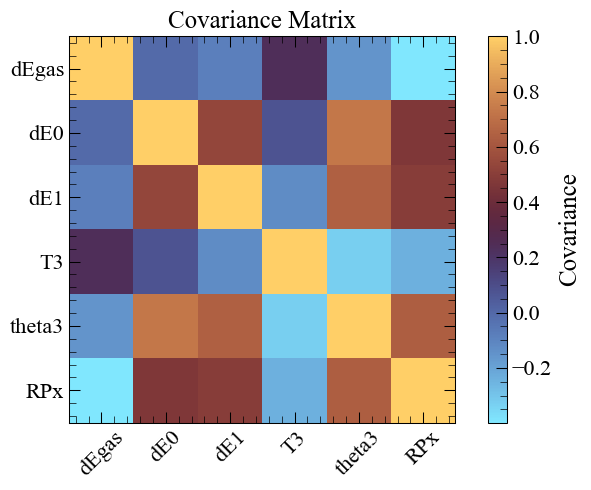

In [18]:
cov_matrix = plain_data.drop(columns=["label", "T3After1"], axis=1).corr()

plt.imshow(cov_matrix, cmap='managua_r', interpolation='none')
plt.colorbar(label='Covariance')
plt.xticks(range(len(cov_matrix.columns)), cov_matrix.columns, rotation=45)
plt.yticks(range(len(cov_matrix.index)), cov_matrix.index)
plt.title('Covariance Matrix')
plt.tight_layout()

In [47]:
## Convert to numpy
X = plain_data.drop(columns=["label", "T3", "T3After1"]).values
X_prof = np.stack(prof_data["profy"].values).astype(np.float32)
X_prof = X_prof[..., np.newaxis] ## Keras expects (Nevents, Nsamples, Nfeatures = 1)
## so we have to force the adding of an auxiliary axis to have the correct shape
y = plain_data["label"].values

# Encode str labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Normalize DNN features
scaler = StandardScaler()
X_scaled = scaler.fit_transform((X))

### Defining the model

 This is a simple sequential mode, consisting of different fully connected layers (a dense or deep neural network, *DNN*)

In [20]:
model = Sequential([
    Input(shape=(X_scaled.shape[1],)), 
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(len(encoder.classes_), activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

2025-05-30 17:32:16.838033: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,723 (26.26 KB)

 Trainable params: 6,723 (26.26 KB)

 Non-trainable params: 0 (0.00 B)

### Train and eval

In [21]:
early = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
history = model.fit(X_scaled, y_encoded, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early])

Epoch 1/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 3s 992us/step - accuracy: 0.7117 - loss: 0.6304 - val_accuracy: 0.7821 - val_loss: 0.4944
Epoch 2/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 2s 938us/step - accuracy: 0.7846 - loss: 0.4927 - val_accuracy: 0.7933 - val_loss: 0.4728
Epoch 3/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 2s 927us/step - accuracy: 0.7926 - loss: 0.4703 - val_accuracy: 0.7957 - val_loss: 0.4651
Epoch 4/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 2s 962us/step - accuracy: 0.7934 - loss: 0.4672 - val_accuracy: 0.7973 - val_loss: 0.4627
Epoch 5/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 2s 931us/step - accuracy: 0.7959 - loss: 0.4630 - val_accuracy: 0.7986 - val_loss: 0.4577
Epoch 6/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 2s 923us/step - accuracy: 0.7965 - loss: 0.4610 - val_accuracy: 0.7961 - val_loss: 0.4611
Epoch 7/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 2s 958us/step - accuracy: 0.7959 - loss: 0.4597 - val_accuracy: 0.7943 - val_loss: 0.4646
Epoch 8/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 2s 940us/step - accuracy: 0.8000 -

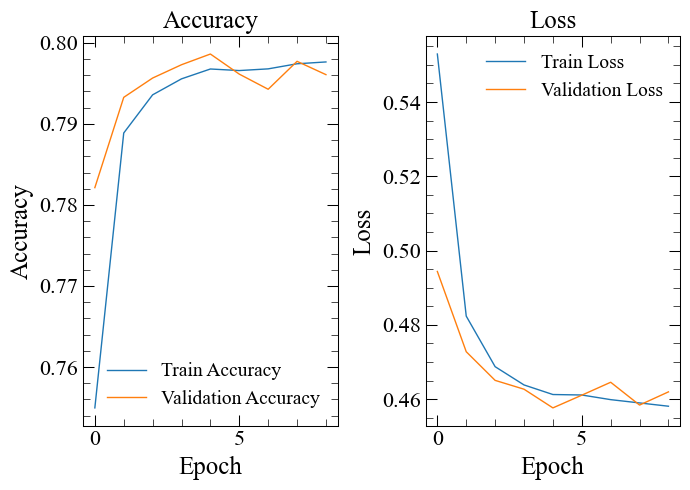

In [22]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

4854/4854 ━━━━━━━━━━━━━━━━━━━━ 2s 444us/step


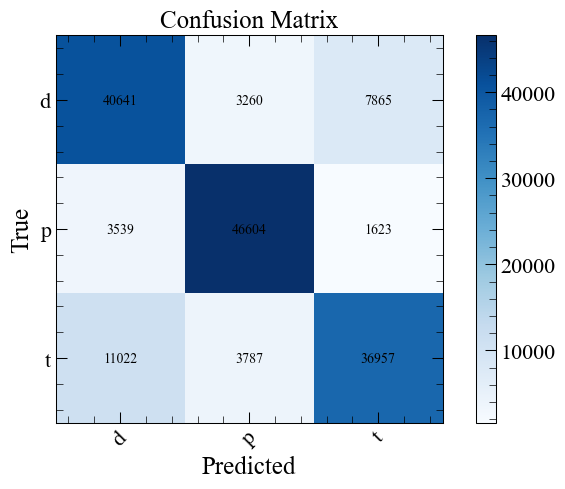

In [23]:
# Confusion matrix
y_pred = model.predict(X_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_encoded, y_pred_classes)

plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Add color bar
plt.colorbar()

# Annotate matrix with counts
classes = encoder.classes_
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

# Set ticks
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)

plt.tight_layout()

Which region is poorly reconstructed?

In [26]:
misclassified = (y_pred_classes != y_encoded)

df_mis = plain_data[misclassified].copy()
df_mis["label_rec"] = encoder.inverse_transform(y_pred_classes[misclassified])
df_mis.head()

,dEgas,dE0,dE1,T3,theta3,RPx,T3After1,label,label_rec
11,0.256664,6.713848,10.852527,38.980803,16.482260,22.404894,21.111035,d,p
19,0.338610,7.592147,9.308926,27.475726,8.367663,92.593678,10.169486,p,d
24,0.364802,6.389269,8.680560,41.912791,6.911770,19.602310,26.496482,d,p
29,0.596601,7.873032,10.778163,38.941992,14.766285,89.314173,19.542990,d,t
30,0.053372,7.362648,9.819344,54.439217,13.738522,158.868882,37.121209,t,p


ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7dc2c530dd50>, cbar=None, text=[])

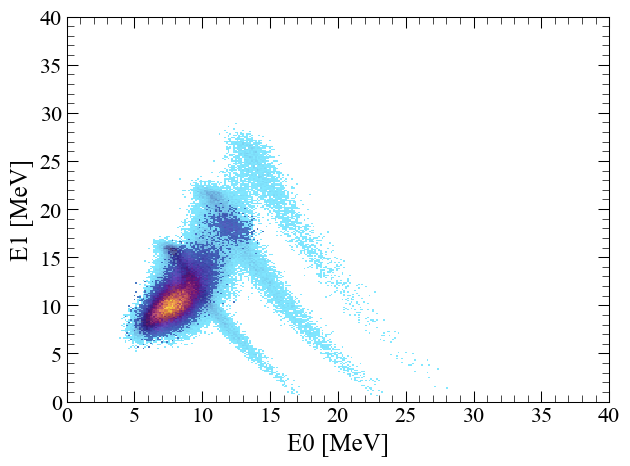

In [27]:
hdE01Mis = hdE01.copy()
hdE01Mis.reset()
hdE01Mis.fill(df_mis["dE0"], df_mis["dE1"])

hdE01.plot(cmin = 1, cmap="managua_r", cbar=None)
hdE01Mis.plot(cmin = 1, cmap="plasma", alpha=0.5, cbar=None)

So it seems it is really complicated to separate particles with this method: the NN won't do anything we cannot separate by hand: $\theta$ is a free parameter that allows the event to be either (d,p), (d,d) or (d,t) by changing Ex.

## Kinematical separation

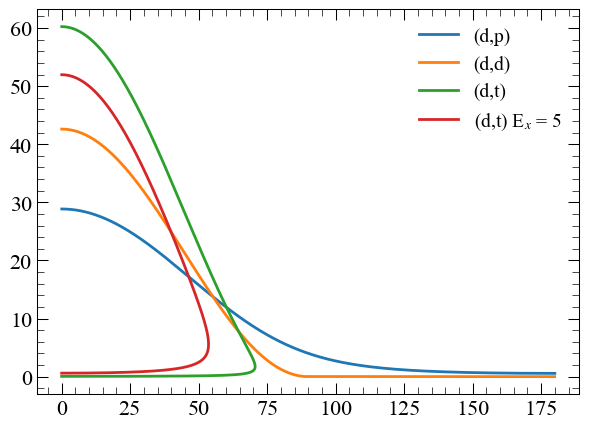

In [28]:

for r in ["(d,p)", "(d,d)", "(d,t)"]:
    k = phys.Kinematics(f"11Li{r}@81.5")
    plt.plot(*k.get_line3(), lw=2, label=r)
k = phys.Kinematics(f"11Li(d,t)@81.5|5")
plt.plot(*k.get_line3(), lw=2, label=r"(d,t) E$_{x}$ = 5")
plt.legend(fontsize=14)

So reconstruction event-by-event the Elab assuming either p, d or t and checking which events fall within the kinematical boundaries would be fine.

## Conv1D

Attempt to improve reconstruction with a Conv1D layer.

In [41]:
# Plain
plain_in = Input(shape=(X_scaled.shape[1],), name="plain_input")
plain_mod = Sequential([
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu")
], name="plain_mod")
plain_out = plain_mod(plain_in)

# Vector (Conv1D) branch
conv_in = Input(shape=(X_prof.shape[1], X_prof.shape[2]), name="conv_input")
conv_mod = Sequential([
    Conv1D(filters=32, kernel_size=3, strides=1, activation="relu", padding="same"),
    Conv1D(filters=16, kernel_size=3, strides=3, activation="relu", padding="same"),
    Flatten(),
    Dense(16, activation="relu")
], name="conv_mod")
conv_out = conv_mod(conv_in)

# Concatenate outputs
combined = Concatenate()([plain_out, conv_out])
x = Dense(32, activation="relu")(combined)
output = Dense(len(encoder.classes_), activation="softmax")(x)

model = Model(inputs=[plain_mod.input, conv_mod.input], outputs=output)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ plain_input         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_input          │ (None, 145, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ plain_mod           │ (None, 32)        │      6,624 │ plain_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_mod            │ (None, 16)        │     14,240 │ conv_input[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 48)        │          0 │ plain_mod[0][0],  │
│ (Concatenate)       │                   │            │ conv_mod[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │      1,568 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 3)         │         99 │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,531 (88.01 KB)

 Trainable params: 22,531 (88.01 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
history = model.fit(
    [X_scaled, X_prof],  # List of inputs
    y_encoded,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early]
)

Epoch 1/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7129 - loss: 0.6238 - val_accuracy: 0.7874 - val_loss: 0.4874
Epoch 2/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7889 - loss: 0.4800 - val_accuracy: 0.7960 - val_loss: 0.4659
Epoch 3/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7925 - loss: 0.4686 - val_accuracy: 0.7966 - val_loss: 0.4618
Epoch 4/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7940 - loss: 0.4654 - val_accuracy: 0.7976 - val_loss: 0.4625
Epoch 5/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7945 - loss: 0.4653 - val_accuracy: 0.7972 - val_loss: 0.4618
Epoch 6/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7978 - loss: 0.4585 - val_accuracy: 0.7982 - val_loss: 0.4608
Epoch 7/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7950 - loss: 0.4620 - val_accuracy: 0.8003 - val_loss: 0.4561
Epoch 8/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8044 - loss: 0.4419 - 

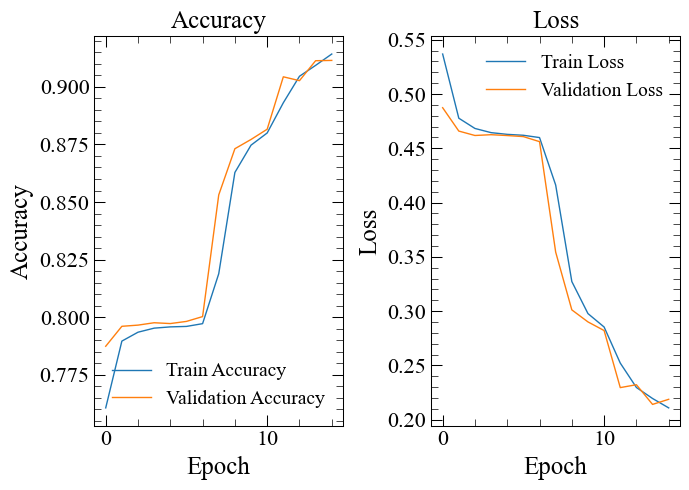

In [49]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

4854/4854 ━━━━━━━━━━━━━━━━━━━━ 4s 891us/step


ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7dc2bedce320>, cbar=None, text=[])

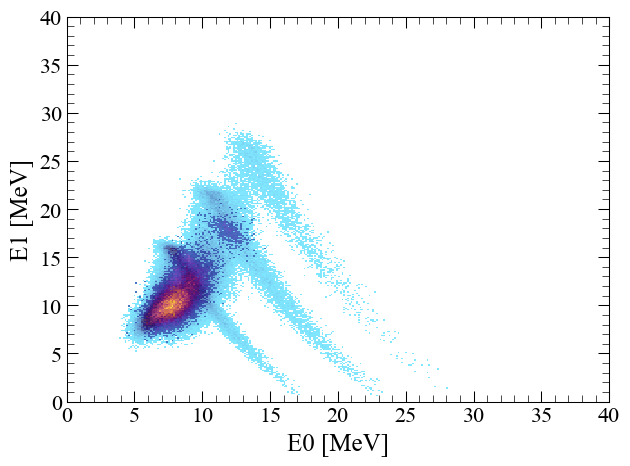

In [50]:
# Confusion matrix
y_pred = model.predict([X_scaled, X_prof])
y_pred_classes = np.argmax(y_pred, axis=1)

misclassified = (y_pred_classes != y_encoded)

df_mis = plain_data[misclassified].copy()
df_mis["label_rec"] = encoder.inverse_transform(y_pred_classes[misclassified])
df_mis.head()
hdE01Mis = hdE01.copy()
hdE01Mis.reset()
hdE01Mis.fill(df_mis["dE0"], df_mis["dE1"])

hdE01.plot(cmin = 1, cmap="managua_r", cbar=None)
hdE01Mis.plot(cmin = 1, cmap="plasma", alpha=0.5, cbar=None)